# Demonstration 2
#### *End-to-end ML pipeline using Black Friday dataset to increase profits*

Rohisha Adke  
May 2019

*Copyright Accenture 2019*

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import re
import xgboost as xgb

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict

from google.cloud import bigquery

sns.set_style("whitegrid")
sns.set_palette("muted")

## 1. Pull data from BigQuery

In [2]:
%%bigquery bf
SELECT
    *
FROM `bfdata.raw`

In [3]:
bf.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1003521,P00350942,M,26-35,0,B,3,0,3,4.0,5.0,10718
1,1003521,P00117442,M,26-35,0,B,3,0,5,14.0,NaN,8643
2,1003521,P00295942,M,26-35,0,B,3,0,2,5.0,15.0,13002
3,1003521,P00089442,M,26-35,0,B,3,0,8,NaN,NaN,9784
4,1003521,P00086042,M,26-35,0,B,3,0,8,14.0,17.0,9764


## 2. Assess dataset, change column types

In [68]:
bf.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1003521,P00350942,M,26-35,0,B,3,0,3,4.0,5.0,10718
1,1003521,P00117442,M,26-35,0,B,3,0,5,14.0,NaN,8643
2,1003521,P00295942,M,26-35,0,B,3,0,2,5.0,15.0,13002
3,1003521,P00089442,M,26-35,0,B,3,0,8,NaN,NaN,9784
4,1003521,P00086042,M,26-35,0,B,3,0,8,14.0,17.0,9764


In [105]:
bf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 537577 entries, 0 to 37576
Data columns (total 12 columns):
User_ID                       537577 non-null category
Product_ID                    537577 non-null category
Gender                        537577 non-null category
Age                           537577 non-null category
Occupation                    537577 non-null category
City_Category                 537577 non-null category
Stay_In_Current_City_Years    537577 non-null category
Marital_Status                537577 non-null category
Product_Category_1            537577 non-null category
Product_Category_2            370591 non-null category
Product_Category_3            164278 non-null category
Purchase                      537577 non-null int64
dtypes: category(11), int64(1)
memory usage: 35.3 MB


In [32]:
bf.dtypes

User_ID                         int64
Product_ID                     object
Gender                         object
Age                            object
Occupation                      int64
City_Category                  object
Stay_In_Current_City_Years     object
Marital_Status                  int64
Product_Category_1              int64
Product_Category_2            float64
Product_Category_3            float64
Purchase                        int64
dtype: object

In [11]:
cat_cols = [col for col in bf.columns if col != 'Purchase']

bf[cat_cols] = bf[cat_cols].astype('category')

In [12]:
bf.dtypes

User_ID                       category
Product_ID                    category
Gender                        category
Age                           category
Occupation                    category
City_Category                 category
Stay_In_Current_City_Years    category
Marital_Status                category
Product_Category_1            category
Product_Category_2            category
Product_Category_3            category
Purchase                         int64
dtype: object

In [36]:
bf.describe().T

,count,mean,std,min,25%,50%,75%,max
Purchase,537577.0,9333.859853,4981.022133,185.0,5866.0,8062.0,12073.0,23961.0


In [50]:
pd.DataFrame(bf.nunique()).rename(columns={0:'Number Unique'})

,Number Unique
User_ID,5891
Product_ID,3623
Gender,2
Age,7
Occupation,21
City_Category,3
Stay_In_Current_City_Years,5
Marital_Status,2
Product_Category_1,18
Product_Category_2,17


## 3. Exploratory data analysis

### a. Assess distributions of columns

Gender
  Gender      ct
0      F  132197
1      M  405380


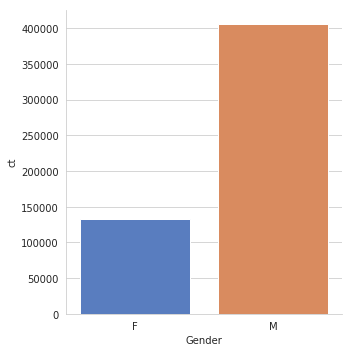

Age
     Age      ct
0   0-17   14707
1  18-25   97634
2  26-35  214690
3  36-45  107499
4  46-50   44526
5  51-55   37618
6    55+   20903


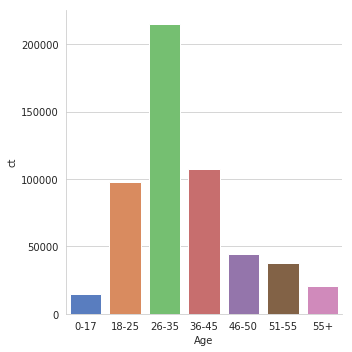

Occupation
   Occupation     ct
0           0  68120
1           1  45971
2           2  25845
3           3  17366
4           4  70862
5           5  11985
6           6  19822
7           7  57806
8           8   1524
9           9   6153
10         10  12623
11         11  11338
12         12  30423
13         13   7548
14         14  26712
15         15  11812
16         16  24790
17         17  39090
18         18   6525
19         19   8352
20         20  32910


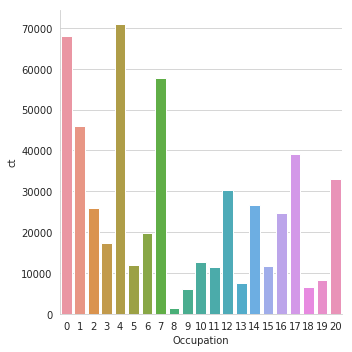

City_Category
  City_Category      ct
0             A  144638
1             B  226493
2             C  166446


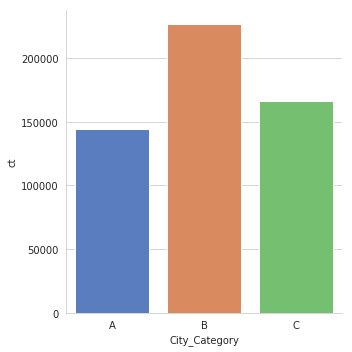

Stay_In_Current_City_Years
  Stay_In_Current_City_Years      ct
0                          0   72725
1                          1  189192
2                          2   99459
3                          3   93312
4                         4+   82889


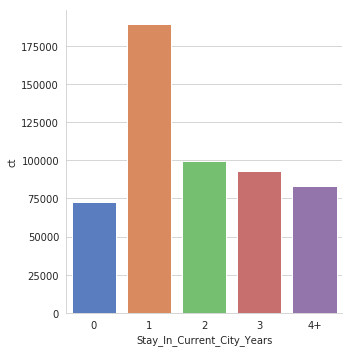

Marital_Status
  Marital_Status      ct
0              0  317817
1              1  219760


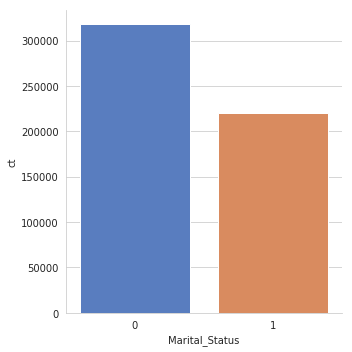

Product_Category_1
   Product_Category_1      ct
0                   1  138353
1                   2   23499
2                   3   19849
3                   4   11567
4                   5  148592
5                   6   20164
6                   7    3668
7                   8  112132
8                   9     404
9                  10    5032
10                 11   23960
11                 12    3875
12                 13    5440
13                 14    1500
14                 15    6203
15                 16    9697
16                 17     567
17                 18    3075


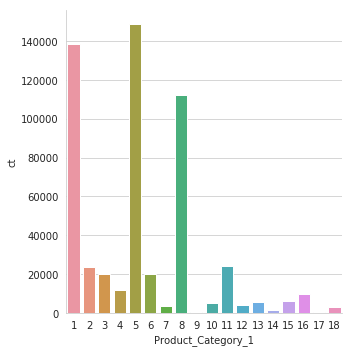

Product_Category_2
   Product_Category_2     ct
0                 2.0  48481
1                 3.0   2835
2                 4.0  25225
3                 5.0  25874
4                 6.0  16251
5                 7.0    615
6                 8.0  63058
7                 9.0   5591
8                10.0   2991
9                11.0  13945
10               12.0   5419
11               13.0  10369
12               14.0  54158
13               15.0  37317
14               16.0  42602
15               17.0  13130
16               18.0   2730


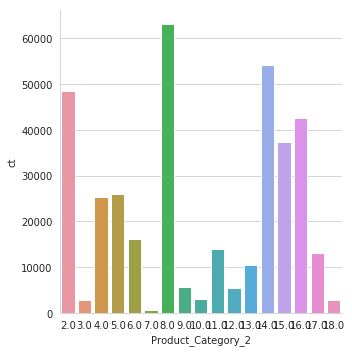

Product_Category_3
   Product_Category_3     ct
0                 3.0    600
1                 4.0   1840
2                 5.0  16380
3                 6.0   4818
4                 8.0  12384
5                 9.0  11414
6                10.0   1698
7                11.0   1773
8                12.0   9094
9                13.0   5385
10               14.0  18121
11               15.0  27611
12               16.0  32148
13               17.0  16449
14               18.0   4563


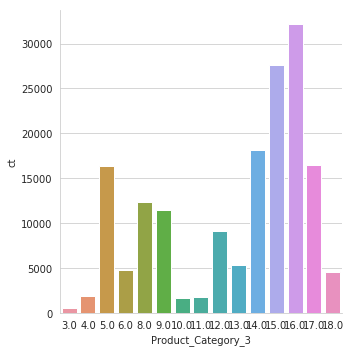

In [13]:
non_id_cols = [col for col in list(bf.columns) if col not in ['User_ID', 'Product_ID', 'Purchase']]

for col in non_id_cols:
    print(col)
    cts = bf.groupby([col])[col].agg({'count'}). \
             rename(columns={'count':'ct'}).reset_index()
    print(cts)
    sns.catplot(x=col, y='ct', data=cts, kind='bar')
    plt.show()


Gender


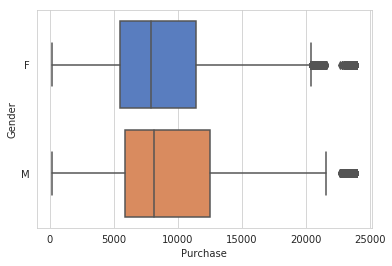

Age


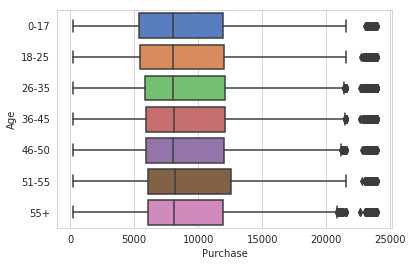

Occupation


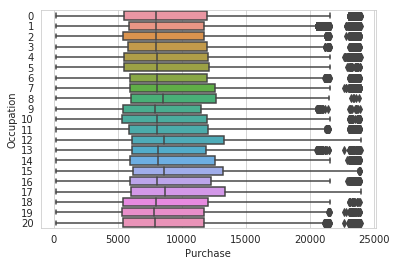

City_Category


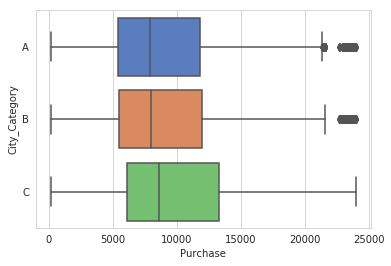

Stay_In_Current_City_Years


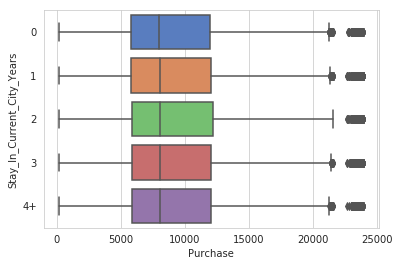

Marital_Status


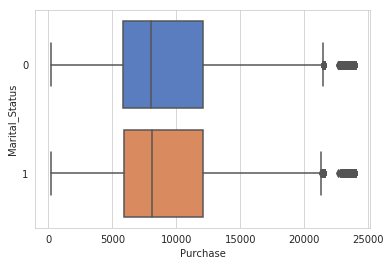

Product_Category_1


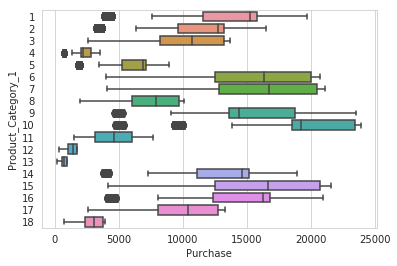

Product_Category_2


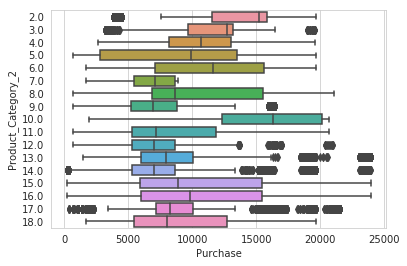

Product_Category_3


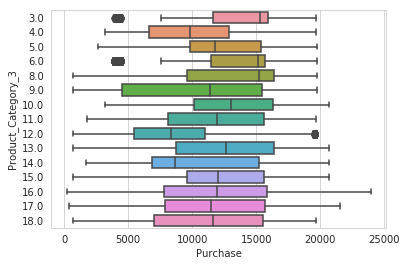

In [14]:
for col in non_id_cols:
    print(col)
    sns.boxplot("Purchase", col, data=bf);
    plt.show()

Not much variation in aggregate purchase amounts when grouping by variables that are not product categories.

#### Q: Is each Product_ID always purchased for the same price?

In [45]:
prod_price = bf.groupby(['Product_ID']).Purchase.agg(['count', 'mean', 'median', 'min',
                                                      'max', 'std'])
prod_price

,count,mean,median,min,max,std
Product_ID,,,,,,
P00000142,1130,11143.507080,10925.5,2725,13716,2307.942795
P00000242,371,10552.293801,10023.0,3214,16503,3179.231273
P00000342,238,5299.928571,5286.5,1727,8896,1834.617830
P00000442,92,4795.358696,5194.0,1764,8891,1664.088125
P00000542,146,5419.308219,5375.0,1730,8903,1742.058891
P00000642,512,14913.238281,15510.0,3950,19705,3633.142520
P00000742,238,6033.441176,5444.0,1723,8902,1631.819453
P00000842,36,10008.722222,9987.0,3347,13322,2664.654463
P00000942,54,10614.500000,9921.5,4022,19154,4371.054282


 #### A: No - purchase price can vary quite a bit for the same Product_ID.

#### Q: How many times is each Product_ID purchased?
#### A: (see plot)

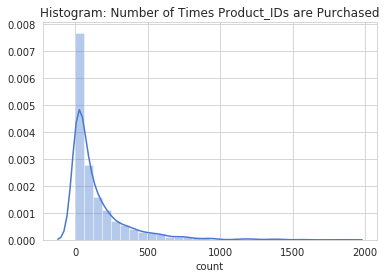

In [46]:
sns.distplot(prod_price['count'], rug=False, bins=30);
plt.title('Histogram: Number of Times Product_IDs are Purchased');

#### Q: For specific Product_IDs, how is purchase amount distributed?

/usr/local/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


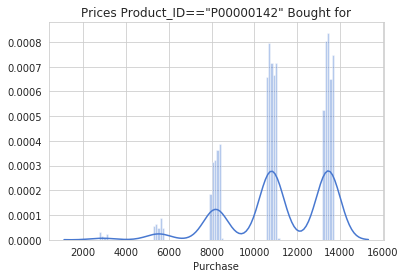

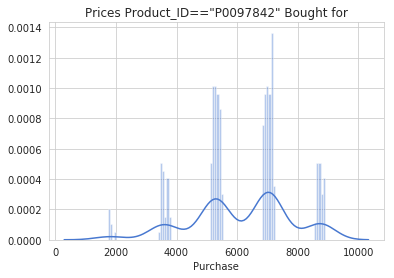

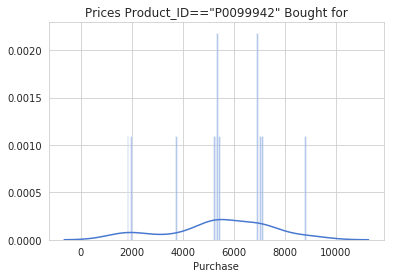

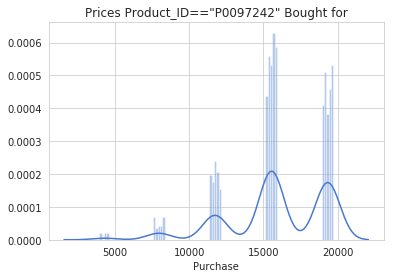

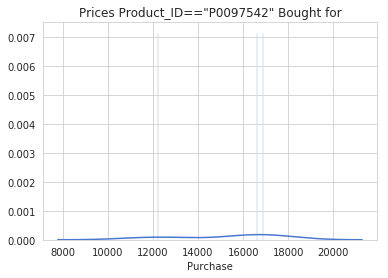

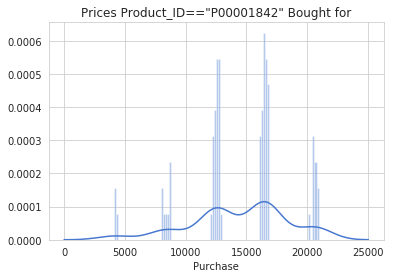

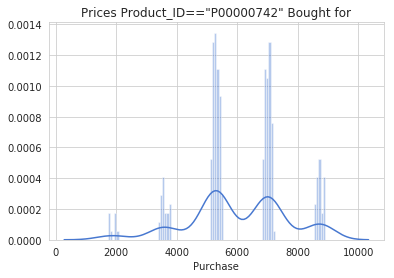

In [15]:
# Plot histograms of purchase amount for specific (randomly selected) Product_IDs

for pid in ['P00000142', 'P0097842', 'P0099942', 'P0097242', 'P0097542', 'P00001842', 'P00000742']:
    sns.distplot(bf[bf.Product_ID==pid].Purchase, bins=100);
    plt.title('Prices Product_ID=="{}" Bought for'.format(pid))
    plt.show()

#### A: Multimodal distribution. Purchase amount varies quite a bit but clusters in certain areas - possibly at regular intervals.

#### Q: What explains these differences in purchase amount for the same product?

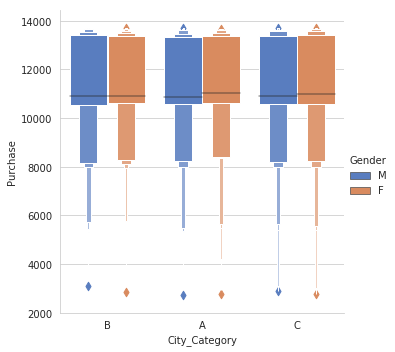

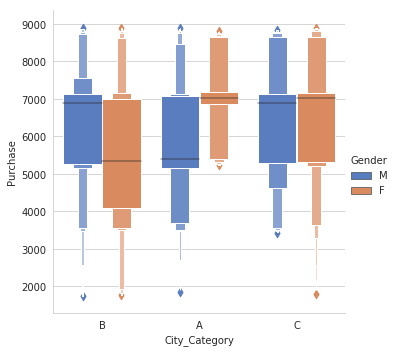

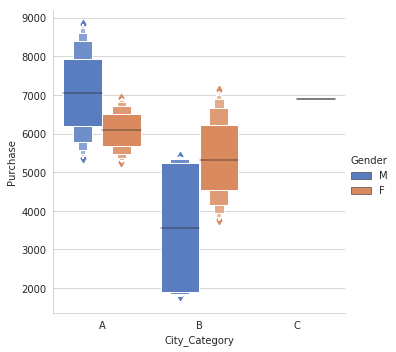

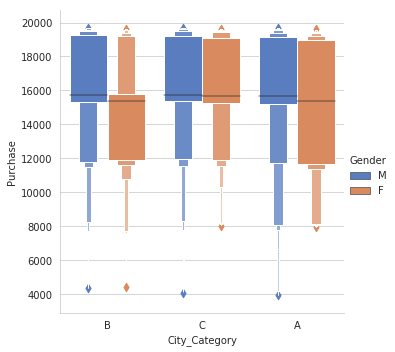

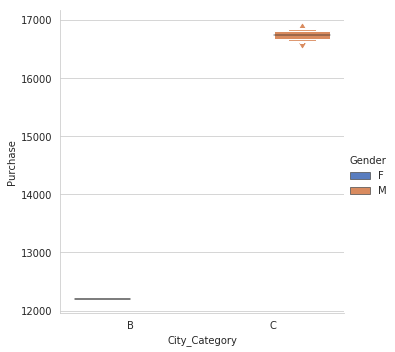

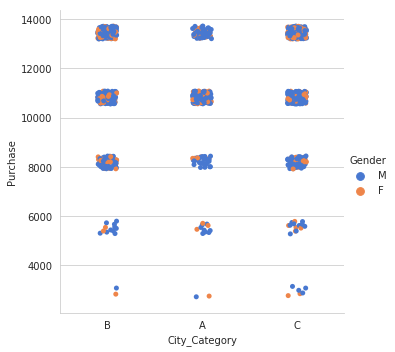

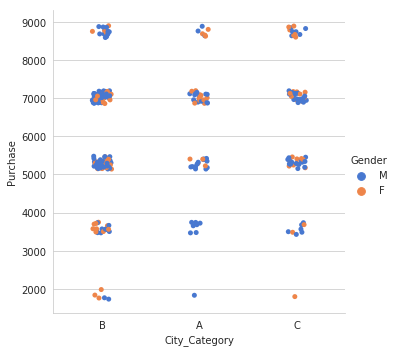

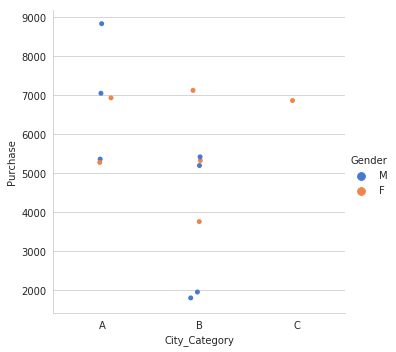

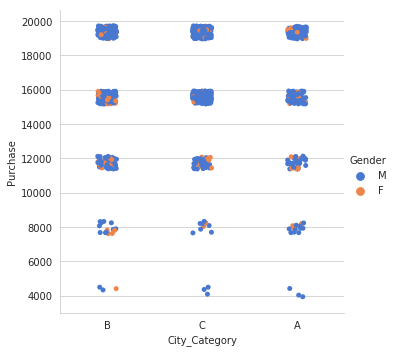

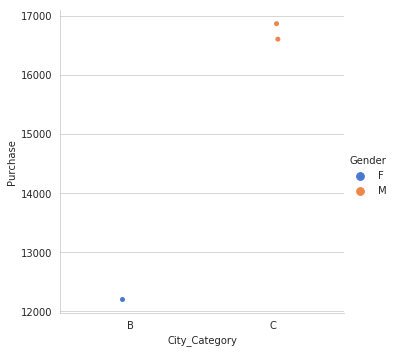

In [110]:
for pid in ['P00000142', 'P0097842', 'P0099942', 'P0097242', 'P0097542']:
    #plt.plot(.City_Category, bf[bf.Product_ID==pid].Purchase );
    #plt.title('Histogram: Prices Product_ID=="{}" Bought for'.format(pid))
    sns.catplot("City_Category", "Purchase", kind='boxen', hue='Gender', data=bf[bf.Product_ID==pid]);
    plt.show()
    
for pid in ['P00000142', 'P0097842', 'P0099942', 'P0097242', 'P0097542']:
    #plt.plot(.City_Category, bf[bf.Product_ID==pid].Purchase );
    #plt.title('Histogram: Prices Product_ID=="{}" Bought for'.format(pid))
    sns.catplot("City_Category", "Purchase", hue='Gender', data=bf[bf.Product_ID==pid]);
    plt.show()

#### Data quality check: is each product always in the same categories? Answer: Yes.

In [52]:
# is each product always in the same category? # answer: yes (same len as # unique Product_ID)
prod_cat1 = bf.groupby(['Product_ID', 'Product_Category_1']).agg(['count'])
print(prod_cat1.shape)
prod_cat1.head()

(3623, 10)


,,User_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_2,Product_Category_3,Purchase
,,count,count,count,count,count,count,count,count,count,count
Product_ID,Product_Category_1,,,,,,,,,,
P00000142,3,1130,1130,1130,1130,1130,1130,1130,1130,1130,1130
P00000242,2,371,371,371,371,371,371,371,371,371,371
P00000342,5,238,238,238,238,238,238,238,238,0,238
P00000442,5,92,92,92,92,92,92,92,92,0,92
P00000542,5,146,146,146,146,146,146,146,0,0,146


In [20]:
# Aggregate amount purchased by user --

# products purchased per user
user_prods = bf.groupby(['User_ID', 'Product_ID']).Product_ID.agg(['count'])

user_prods[user_prods['count']!=1] 
# no user buys the same product twice - data quality? Can the same product have different Product_IDs? 
# If a user buys 3 of the same product, is the "purchase" price listed with the product_ID actually the price of 3 of the products?


,,count
User_ID,Product_ID,


In [18]:
user_prods.shape

(537577, 1)

In [21]:
# prices purchased per user
users = bf.groupby(['User_ID']).Purchase. \
    agg(['count','sum', 'mean', 'median', 'min', 'max', 'std']). \
    rename(columns={'count':'prod_type_ct', 'sum':'purchase_total'})

users.head()

,prod_type_ct,purchase_total,mean,median,min,max,std
User_ID,,,,,,,
1000001,34,333481,9808.264706,9974.5,1057,19219,4437.481236
1000002,76,810353,10662.539474,9929.5,3443,20657,4157.968816
1000003,29,341635,11780.517241,12103.0,3646,19631,5358.428805
1000004,13,205987,15845.153846,15853.0,3849,19693,4265.866204
1000005,106,821001,7745.292453,6168.0,1938,21021,4110.717354


#### Q: How many products does each user buy?
#### A: (see plot)

In [32]:
users.purchase_total.describe()

count    5.891000e+03
mean     8.517515e+05
std      9.329978e+05
min      4.410800e+04
25%      2.349140e+05
50%      5.126120e+05
75%      1.099005e+06
max      1.053678e+07
Name: purchase_total, dtype: float64

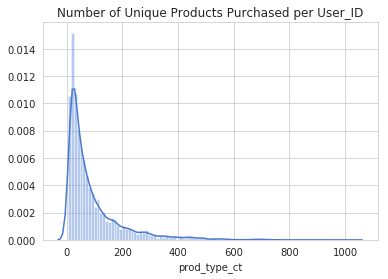

In [22]:
sns.distplot(users['prod_type_ct'], bins=100);
plt.title('Number of Unique Products Purchased per User_ID');

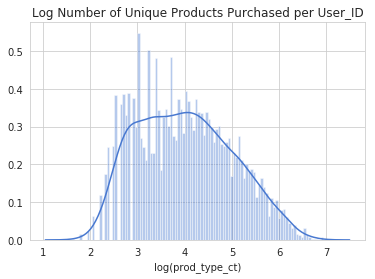

In [41]:
sns.distplot(np.log(users['prod_type_ct']), bins=100);
plt.title('Log Number of Unique Products Purchased per User_ID');
plt.xlabel('log(prod_type_ct)');

#### Q: How much does each user spend total?
#### A: (see plot)

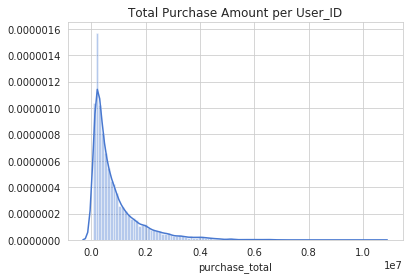

In [23]:
sns.distplot(users['purchase_total'], bins=100); # some quite high. are some users businesses?
plt.title('Total Purchase Amount per User_ID');

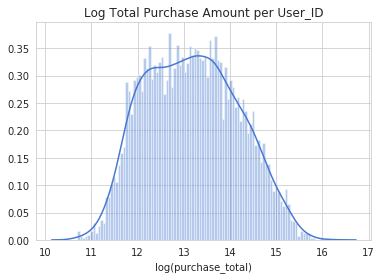

In [37]:
sns.distplot(np.log(users['purchase_total']), bins=100); # some quite high. are some users businesses?
plt.title('Log Total Purchase Amount per User_ID');
plt.xlabel('log(purchase_total)');

In [50]:
users.sort_values('purchase_total', ascending=False)

,prod_type_ct,purchase_total,mean,median,min,max,std
User_ID,,,,,,,
1004277,978,10536783,10773.806748,9738.5,568,23615,4889.522382
1001680,1025,8699232,8487.055610,7762.0,391,23631,4690.901573
1002909,717,7577505,10568.347280,9714.0,563,23446,5655.394562
1001941,898,6817493,7591.863029,6831.5,405,21160,4720.768065
1000424,694,6573609,9472.059078,8034.5,383,23733,4836.460393
1004448,574,6565878,11438.811847,9934.0,379,23050,5163.825728
1001015,739,6511302,8810.963464,7879.0,384,23591,4639.305154
1003391,697,6476786,9292.375897,8593.0,185,23883,5056.736807
1001181,861,6387899,7419.162602,6121.0,372,23579,4107.447824


#### Q: What is the relationship between the number of unique Product_IDs bought and total purchase amount for each user?
#### A: (see plot)

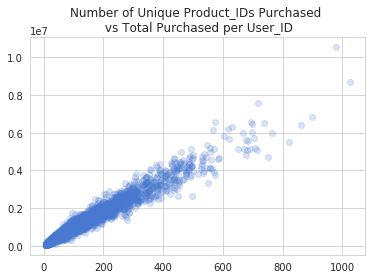

In [57]:
plt.scatter('prod_type_ct', 'purchase_total', data=users, alpha=.2);
plt.title('Number of Unique Product_IDs Purchased \n vs Total Purchased per User_ID');

In [56]:
users[['prod_type_ct', 'purchase_total']].corr() 

,prod_type_ct,purchase_total
prod_type_ct,1.000000,0.978977
purchase_total,0.978977,1.000000


Count of unique products purchased (number of Product_IDs) is highly positvely correlated to total amount purchased. Unfortunately, we cannot use this variable to predict total amount purchased, as we would not know number of unique products purchased before Black Friday occurs. In practice, it may be more useful to use past purchase history to predict Black Friday purchase behavior, instead of attempting to use high-level user attributes.

### 4a. Preprocessing & final dataset EDA

In [46]:
# create table of user info

user_cols = ['User_ID', 'Gender', 'Age', 'Occupation', 'City_Category',
             'Stay_In_Current_City_Years', 'Marital_Status']
user_info = bf[user_cols].groupby(user_cols).User_ID.agg(['count']) \
                         .rename(columns={'count':'prod_type_ct'}).reset_index()

In [12]:
len(user_info)
sum(user_info.prod_type_ct)
# same length as unique User_IDs/same total as rows so user info is consistent for each user across dataset (data quality check passes)

537577

In [47]:
# Join info onto users purchase df
users = pd.merge(users, user_info, on=['User_ID', 'prod_type_ct'])

users.head()

,User_ID,prod_type_ct,purchase_total,mean,median,min,max,std,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status
0,1000001,34,333481,9808.264706,9974.5,1057,19219,4437.481236,F,0-17,10,A,2,0
1,1000002,76,810353,10662.539474,9929.5,3443,20657,4157.968816,M,55+,16,C,4+,0
2,1000003,29,341635,11780.517241,12103.0,3646,19631,5358.428805,M,26-35,15,A,3,0
3,1000004,13,205987,15845.153846,15853.0,3849,19693,4265.866204,M,46-50,7,B,2,1
4,1000005,106,821001,7745.292453,6168.0,1938,21021,4110.717354,M,26-35,20,A,1,1


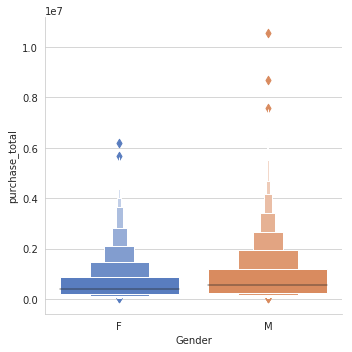

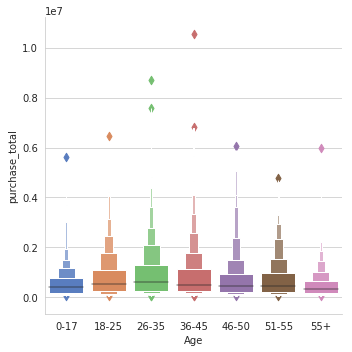

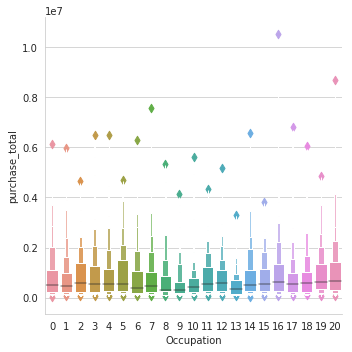

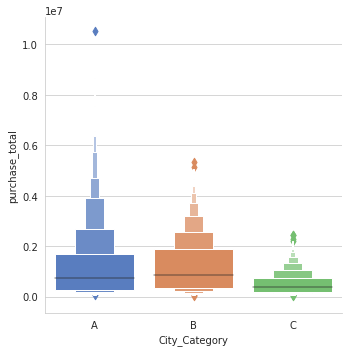

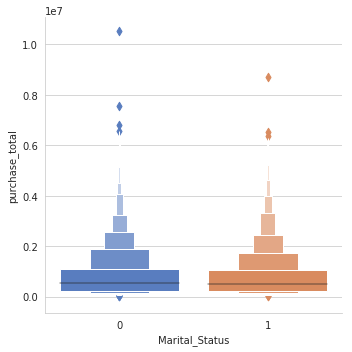

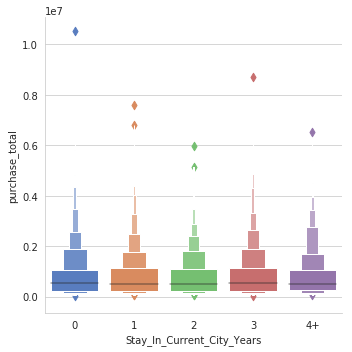

In [104]:
# Data exploration: how do user attributes relate to total purchase amount?

for col in ['Gender', 'Age', 'Occupation', 'City_Category', 'Marital_Status',
            'Stay_In_Current_City_Years']:
    sns.catplot(col, 'purchase_total', kind='boxen', data=users);
    plt.show()

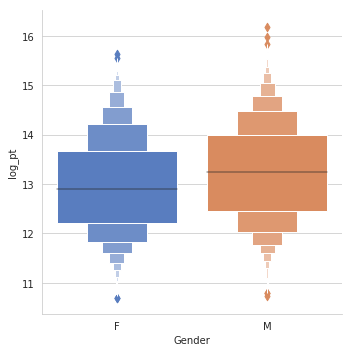

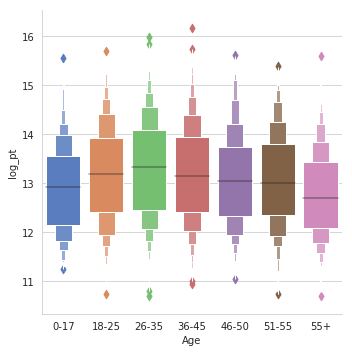

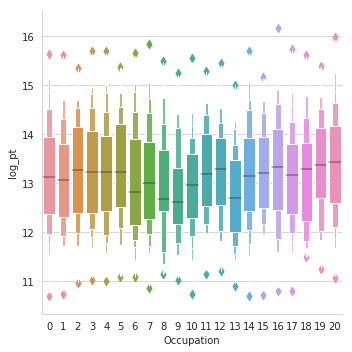

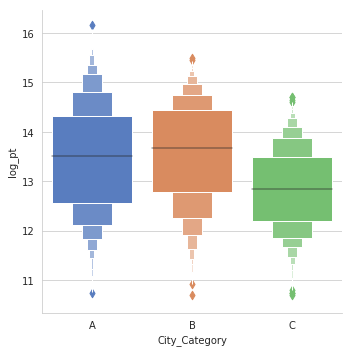

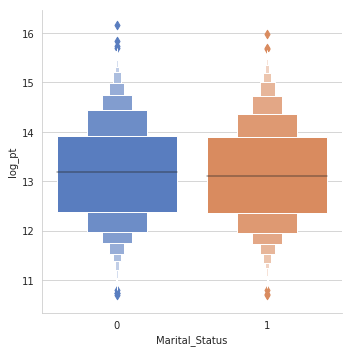

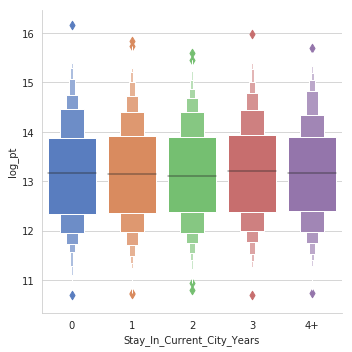

In [59]:
# Data exploration: how do user attributes relate to log total purchase amount?
users['log_pt'] = np.log(users['purchase_total'])

for col in ['Gender', 'Age', 'Occupation', 'City_Category', 'Marital_Status',
            'Stay_In_Current_City_Years']:
    sns.catplot(col, 'log_pt', kind='boxen', data=users);
    plt.show()

## 5. Model training

In [112]:
### ----- Preprocessing (above steps collected here for convenience) -----

# prices purchased per user
users = bf.groupby(['User_ID']).Purchase. \
    agg(['count','sum']). \
    rename(columns={'count':'prod_type_ct', 'sum':'purchase_total'})

user_cols = ['User_ID', 'Gender', 'Age', 'Occupation', 'City_Category',
             'Stay_In_Current_City_Years', 'Marital_Status']
user_info = bf[user_cols].groupby(user_cols).User_ID.agg(['count']) \
                         .rename(columns={'count':'prod_type_ct'}).reset_index()

# Join info onto users purchase df
users = pd.merge(users, user_info, on=['User_ID', 'prod_type_ct'])

# log target variable
users['log_pt'] = np.log(users['purchase_total'])

In [108]:
### ----- One-hot encode categorical variables -----

features = ['Gender', 'Occupation', 'City_Category', 'Age', 
            'Stay_In_Current_City_Years', 'Marital_Status']
y_col = 'log_pt' #'purchase_total'

features_ohot = pd.get_dummies(users[features])
features_ohot.shape

(5891, 40)

In [89]:
### ----- Split into training, validation (for hyperparameter tuning), test (for final model evaluation) datasets -----

X_train, X_test, y_train, y_test = train_test_split(features_ohot,
                                                    users[y_col], test_size=0.18,
                                                    random_state=33,
                                                    shuffle=True)
print(X_train.shape)
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train, test_size=0.22,
                                                  random_state=33,
                                                  shuffle=True)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(4830, 40)
(3767, 40)
(1063, 40)
(1061, 40)


In [90]:
# Linear regression to get a sense for feature coefficients.

lm = sm.OLS(y_train, X_train)

lm_results = lm.fit()
print(lm_results.summary())


lm_no_gender_stay = sm.OLS(y_train,
            X_train[[col for col in X_train.columns if col not in ['Gender_F',
                                                                   'Gender_M',
                                                                   'Stay_In_Current_City_Years_0',
                                                                   'Stay_In_Current_City_Years_1',
                                                                   'Stay_In_Current_City_Years_2',
                                                                   'Stay_In_Current_City_Years_3',
                                                                   'Stay_In_Current_City_Years_4+',
                                                                            #'Marital_Status_0',
                                                                           #'Marital_Status_1'
                                                                  ]]])
lm_no_gs_results = lm_no_gender_stay.fit()
print(lm_no_gs_results.summary())

                            OLS Regression Results                            
Dep. Variable:                 log_pt   R-squared:                       0.160
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     20.90
Date:                Tue, 21 May 2019   Prob (F-statistic):          1.19e-115
Time:                        19:15:41   Log-Likelihood:                -4986.5
No. Observations:                3767   AIC:                         1.004e+04
Df Residuals:                    3732   BIC:                         1.026e+04
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Gender_F      

In [171]:
def fit_predict_evaluate(model_type, X_train, y_train, X_val, y_val, **kwargs):
    '''Fits model_type, predicts on training and validation set and returns fit model and metrics.
       Final kwargs should be expected model parameters depending on model_type.'''
    
    model = None
    
    if model_type=='linreg':
        model = LinearRegression(fit_intercept=kwargs['fit_intercept'])
        
    elif model_type=='lasso':
        model = Lasso(alpha=kwargs['alpha'])

    elif model_type=='ridge':
        model = Ridge(alpha=kwargs['alpha'])
        
    elif model_type=='rf':
        model = RandomForestRegressor(n_estimators=kwargs['n_estimators'], max_depth=kwargs['max_depth'],
                                      max_features=kwargs['max_features'], oob_score=kwargs['oob_score'],
                                      random_state=kwargs['random_state'], warm_start=kwargs['warm_start'])
        
        if kwargs['plot_rf_importances']:
            importances = pd.DataFrame(X_train.columns, rf.feature_importances_). \
                          reset_index().rename(columns={'index':'importance', 0:'feature'})
            importances.sort_values('importance', ascending=False, inplace=True)
            plt.plot('feature', 'importance', data=importances);
            plt.xticks(rotation='vertical');
            plt.show()
    
    elif model_type=='xgb':
        model = xgb.XGBRegressor(max_depth=kwargs['max_depth'], learning_rate=kwargs['learning_rate'], 
                                 n_estimators=kwargs['n_estimators'], reg_alpha=kwargs['reg_alpha'], 
                                 colsample_bytree=kwargs['colsample_bytree'], colsample_bylevel=kwargs['colsample_bylevel'],
                                 colsample_bynode=kwargs['colsample_bynode'], verbosity=kwargs['verbosity'])
        
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    val_pred = model.predict(X_val)
    model_metrics = {'train_rmse': np.sqrt(mean_squared_error(y_train, 
                         train_pred)),
                     'val_rmse': np.sqrt(mean_squared_error(y_val, val_pred)),
                     'train_mae':mean_absolute_error(y_train, 
                         train_pred),
                     'val_mae': mean_absolute_error(y_val, val_pred),
                     'train_mae_raw': mean_absolute_error(np.exp(y_train), 
                         np.exp(train_pred)),
                     'val_mae_raw': mean_absolute_error(np.exp(y_val), 
                         np.exp(val_pred))
                    }
    
    return(model, model_metrics)

In [147]:
### ----- Linear regression -----

lr, lr_metrics = fit_predict_evaluate('linreg', X_train, y_train, X_val, y_val, fit_intercept=True)

### ----- Lasso -----

# Lasso - increasing regularization hurts train/val RMSE/MAE. 
# Seems to indicate that lack of signal in the features is the issue -
#    not overfitting or having many features.

lo, lasso_metrics = fit_predict_evaluate('lasso', X_train, y_train, X_val, y_val, alpha=0.3)

### ----- XGBoost -----

xm_deep, xm_deep_metrics = fit_predict_evaluate('xgb', X_train, y_train, X_val, y_val, 
                                                max_depth=30, learning_rate= 0.3, n_estimators=200, reg_alpha=0.8, 
                                                colsample_bytree = 0.5, colsample_bylevel = 0.5, colsample_bynode = 0.5,
                                                verbosity=3)

xm_shallow, xm_shallow_metrics = fit_predict_evaluate('xgb', X_train, y_train, X_val, y_val, 
                                                max_depth=5, learning_rate=0.3, n_estimators=500, reg_alpha=0.8, 
                                                colsample_bytree = 0.5, colsample_bylevel = 0.2, colsample_bynode = 0.2,
                                                verbosity=3)


{'train_mae': 0.8301643188069072,
 'train_mae_raw': 587319.4960937568,
 'train_rmse': 0.9919856182889352,
 'val_mae': 0.8193490150752438,
 'val_mae_raw': 604081.0692281189,
 'val_rmse': 0.9871040653208271}

In [149]:
# Ridge regression - search over alpha values.

rr_train_mae = []
rr_val_mae = []
alpha_vals = []

for a in range(0, 10):
    al = 0.01+a/10
    rr, rr_metrics = fit_predict_evaluate('ridge', X_train, y_train, X_val, y_val, alpha=al)
    
    alpha_vals.append(al)
    rr_train_mae.append(rr_metrics['train_mae_raw'])
    rr_val_mae.append(rr_metrics['val_mae_raw'])

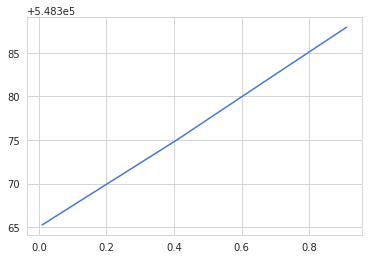

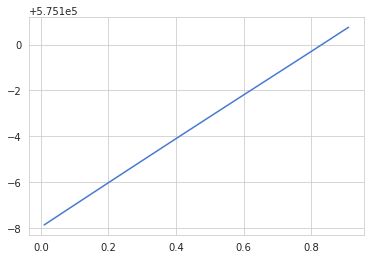

In [150]:
# Plot alpha value vs train/val MSE.

plt.plot(alpha_vals, rr_train_mae)
plt.show()
plt.plot(alpha_vals, rr_val_mae)

# Regularization is only hurting the predictions.

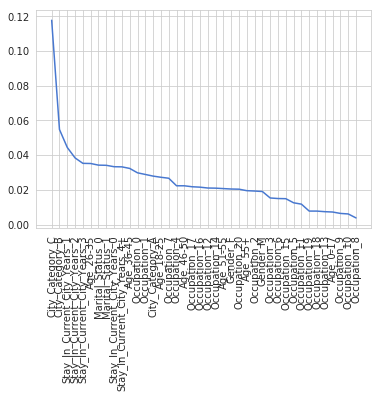

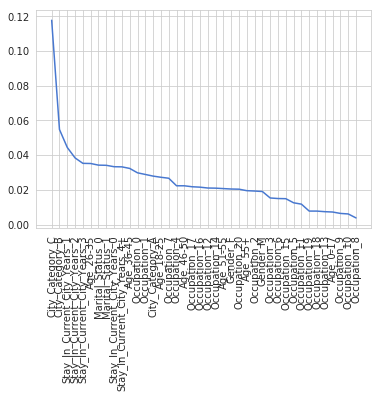

In [166]:
regex = re.compile(r'Age_*') # Gender_*|Marital_Status_*|Stay_In_Current_City_Years_*')

cols_to_exclude = list(filter(regex.search, X_train.columns))
cols_to_include = X_train.columns #[col for col in X_train.columns if col not in cols_to_exclude]
# print(cols_to_include)

# Random Forest

rf, rf_deep_metrics = fit_predict_evaluate('rf', X_train[cols_to_include], y_train, X_val[cols_to_include], y_val, 
                                           n_estimators=100, max_depth=30, max_features=5,
                                           oob_score=True, random_state=533, warm_start=False,
                                           plot_rf_importances = True)
# RF shallow/many
rf_shallow, rf_shallow_metrics = fit_predict_evaluate('rf', X_train[cols_to_include], y_train, X_val[cols_to_include], y_val,
                                                      n_estimators=500, max_depth=5, max_features=5, oob_score=True,
                                                      random_state=533, warm_start=False,
                                                      plot_rf_importances = True)

In [167]:
# rf_train_preds = rf.predict(X_train_subset)
# train_ap = pd.DataFrame({'User_ID':y_train.index, 'actual':y_train, 'pred':rf_train_preds})
# plt.scatter('actual', 'pred', data=train_ap, alpha=.2)
# plt.show()


# train_percentage_error = (y_train-rf_train_preds)/y_train
# print('Mean Train Absolute Percentage Error: {}'.format(np.mean(np.abs(train_percentage_error))))
# 
# print(max(train_percentage_error))
# print(min(train_percentage_error))
# 
# plt.hist(100*train_percentage_error, bins=100);
# plt.title('Histogram: Percentage Train Error');
# plt.show()
# 
# 
# rf_val_preds = rf.predict(X_val_subset)
# val_percentage_error = (np.exp(y_val)-np.exp(rf_val_preds))/np.exp(y_val)
# print('Mean Raw Val Absolute Percentage Error: {}'.format(np.mean(np.abs(val_percentage_error))))
# 
# print(max(val_percentage_error))
# print(min(val_percentage_error))
# 
# plt.hist(100*val_percentage_error, bins=100);
# plt.title('Histogram: Raw Val Percentage Error');
# plt.show()

## 6. Compare model performance (when reach final assessment, compare on held out test set for accurate representation of error)

In [175]:
metrics = pd.DataFrame({'xbg_shallow':xgb_shallow_metrics,
                        'xgb_deep':xgb_deep_metrics,
                        'linreg':lr_metrics, 
                        'lasso':lasso_metrics,
                        'rf':rf_metrics,
                        'rf_shallow':rf_shallow_metrics})

metrics.T.sort_values('val_mae', ascending=True)

,train_mae,train_mae_raw,train_rmse,val_mae,val_mae_raw,val_rmse
xbg_shallow,0.731544,529590.350030,0.873407,0.763248,569448.135186,0.923833
linreg,0.763173,548575.574385,0.909356,0.770775,575800.230396,0.924314
rf_shallow,0.766988,552377.042396,0.910833,0.774697,579456.605502,0.923794
xgb_deep,0.588381,433984.587912,0.720861,0.805849,598438.382011,0.990342
rf,0.524620,390846.594263,0.662571,0.818633,607889.368822,1.008322
lasso,0.830164,587319.496094,0.991986,0.819349,604081.069228,0.987104


Based on current metric of validation MAE, XGBoost shallow is the current best model. The large difference between random forest train and validation MAE/RMSE indicate that tuning is required to not overfit the model to the training set.

### 7. Compare model performance on final test set.

In [102]:
def predict_score(X_test, y_test, model):
    test_pred = model.predict(X_test)
    metrics = {'test_rmse': np.sqrt(mean_squared_error(y_test, 
                             test_pred)),
               'test_mae':mean_absolute_error(y_test, 
                             test_pred),
               'test_mae_raw': mean_absolute_error(np.exp(y_test), 
                             np.exp(test_pred))
              }
    
    return(metrics)

In [103]:
test_metrics = pd.DataFrame({'xbg_shallow':predict_score(X_test, y_test, xm_shallow),
                             'xgb_deep':predict_score(X_test, y_test, xm_deep),
                             'linreg':predict_score(X_test, y_test, lr), 
                             'lasso':predict_score(X_test, y_test, lo),
                             'rf_deep':predict_score(X_test, y_test, rf),
                             'rf_shallow':predict_score(X_test, y_test, rf_shallow)
                            })

test_metrics.T.sort_values('test_mae', ascending=True)

,test_mae,test_mae_raw,test_rmse
linreg,0.777238,575395.780374,0.930636
rf_shallow,0.783923,578874.609689,0.932089
xbg_shallow,0.789911,583842.941520,0.946424
xgb_deep,0.833516,610220.197455,1.018076
rf_deep,0.833830,616312.038174,1.020216
lasso,0.840250,608910.126620,1.000519


### 8. Deploy model on AI Platform

In [ ]:
# xm_shallow.save_model('./model.bst')

# to do: plot predicted vs actual if flag, plot residuals if flag, calc percentage error
# feature selection
# feature plot